In [620]:
import glob
import numpy as np
import PIL
from PIL import Image
from collections import Counter
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import np_utils
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score

### Understand the image data

In [2]:
cat_im = Image.open("data/train/cat.0.jpg")
dog_im = Image.open("data/train/dog.0.jpg")

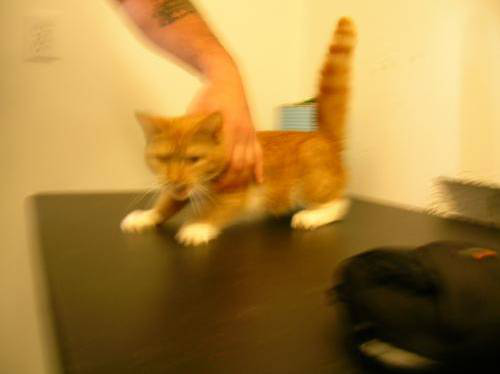

In [3]:
cat_im

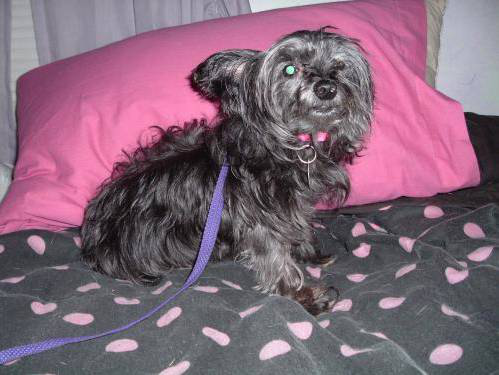

In [4]:
dog_im

In [10]:
cat_im.size

(500, 374)

In [8]:
cat_array = np.array(cat_im.getdata())

In [9]:
cat_array.shape

(187000, 3)

### Keras example input data for CNN 

In [361]:
from keras.datasets import cifar10

In [362]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [363]:
# 3 RBG, 32*32 Image
X_train.shape

(50000, 3, 32, 32)

### Process the images

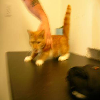

In [365]:
# need to resize image so that numpy concat works
resized_cat = cat_im.resize((100, 100))
resized_cat

In [367]:
np.array(resized_cat).shape

(100, 100, 3)

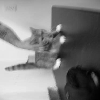

In [369]:
PIL.Image.fromarray(np.array(resized_cat).T[1])

In [440]:
def convert_image_to_data(image):
    image_resized = Image.open(image).resize((100, 100))
    cat_array = np.array(image_resized).T
    return cat_array

In [441]:
cat_files = glob.glob("data/train/cat*")
dog_files = glob.glob("data/train/dog*")

In [442]:
cat_list = []
for i in cat_files[:10]:
    cat_list.append(convert_image_to_data(i))

In [443]:
dog_list = []
for i in dog_files[:10]:
    dog_list.append(convert_image_to_data(i))

In [488]:
y_cat = np.zeros(len(cat_list))

In [489]:
y_dog = np.ones(len(dog_list))

In [478]:
X = np.concatenate([cat_list, dog_list])

In [479]:
# Cast as float32 type
X = X.astype("float32")

In [480]:
X[:2]

array([[[[ 204.,  204.,  204., ...,  159.,  155.,  152.],
         [ 210.,  210.,  210., ...,  161.,  157.,  154.],
         [ 213.,  213.,  213., ...,  164.,  160.,  158.],
         ..., 
         [ 246.,  247.,  248., ...,    3.,    3.,    2.],
         [ 246.,  245.,  245., ...,    3.,    3.,    2.],
         [ 241.,  242.,  244., ...,    2.,    3.,    2.]],

        [[ 165.,  165.,  165., ...,  125.,  124.,  121.],
         [ 171.,  171.,  171., ...,  127.,  126.,  123.],
         [ 174.,  174.,  174., ...,  130.,  129.,  127.],
         ..., 
         [ 209.,  212.,  215., ...,    4.,    3.,    2.],
         [ 205.,  207.,  208., ...,    4.,    3.,    2.],
         [ 202.,  203.,  205., ...,    2.,    3.,    2.]],

        [[  88.,   88.,   88., ...,   54.,   57.,   54.],
         [  94.,   94.,   94., ...,   56.,   59.,   56.],
         [  97.,   97.,   97., ...,   59.,   62.,   60.],
         ..., 
         [ 128.,  131.,  138., ...,    0.,    1.,    0.],
         [ 123.,  126.,

In [481]:
X.shape

(20, 3, 100, 100)

In [494]:
y = np.concatenate([y_cat, y_dog])

In [496]:
# cast as integer
y = y.astype("int")

In [497]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

### Split train data into test/train

In [499]:
X.shape

(20, 3, 100, 100)

In [500]:
y.shape

(20,)

In [581]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=1)

In [582]:
for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [12  3  4 11 19  2  1 13  9 15 10  7  0  6 14 18] TEST: [16  8 17  5]


In [583]:
y_train

array([1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1])

In [584]:
y_test

array([1, 0, 1, 0])

In [585]:
Counter(y_train), Counter(y_test)

(Counter({0: 8, 1: 8}), Counter({0: 2, 1: 2}))

In [612]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

In [613]:
y_train, y_test

(array([1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1]), array([1, 0, 1, 0]))

In [614]:
Counter(y_train), Counter(y_test)

(Counter({0: 8, 1: 8}), Counter({0: 2, 1: 2}))

### Train model and validate it

In [622]:
model = Sequential()
# input: 100x100 images with 3 channels -> (3, 100, 100) tensors.
# this applies 32 convolution filters of size 3x3 each.
model.add(Convolution2D(32, 3, 3, border_mode='valid', input_shape=(3, 100, 100)))
model.add(Activation('relu'))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Convolution2D(64, 3, 3, border_mode='valid'))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
# Note: Keras does automatic shape inference.
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

In [623]:
model.fit(X_train, y_train, batch_size=32, nb_epoch=20)

Epoch 1/20
16/16 [==============================] - 0s - loss: 5.0208 - acc: 0.6875
Epoch 2/20
16/16 [==============================] - 0s - loss: 8.0590 - acc: 0.5000
Epoch 3/20
16/16 [==============================] - 0s - loss: 8.0590 - acc: 0.5000
Epoch 4/20
16/16 [==============================] - 0s - loss: 8.0590 - acc: 0.5000
Epoch 5/20
16/16 [==============================] - 0s - loss: 8.0590 - acc: 0.5000
Epoch 6/20
16/16 [==============================] - 0s - loss: 8.0590 - acc: 0.5000
Epoch 7/20
16/16 [==============================] - 0s - loss: 8.0590 - acc: 0.5000
Epoch 8/20
16/16 [==============================] - 0s - loss: 8.0590 - acc: 0.5000
Epoch 9/20
16/16 [==============================] - 0s - loss: 8.0590 - acc: 0.5000
Epoch 10/20
16/16 [==============================] - 0s - loss: 8.0590 - acc: 0.5000
Epoch 11/20
16/16 [==============================] - 0s - loss: 8.0590 - acc: 0.5000
Epoch 12/20
16/16 [==============================] - 0s - loss: 8.0590 - a

In [618]:
y_test_predict = model.predict(X_test)

In [621]:
accuracy_score(y_test, y_test_predict)

0.5